# Project 1 - part A

Dataset with the 30 Stocks from S&P500 Index from 2014 to 2024

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../project1-partA/project1_data.csv")
df_SP500 = pd.read_csv("../project1-partA/sp500_px_open_last.csv")
df = df.dropna() # VRTX has null PX_LAST in 2015-05-12	
df.head()

,Date,PX_LAST,CUR_MKT_CAP,PX_VOLUME,Ticker,Market_Value
0,2014-01-02,76.27,134027.7199,5212460.0,DIS,1.022229e+07
1,2014-01-03,76.11,133746.5552,4061042.0,DIS,1.017945e+07
2,2014-01-06,75.82,133236.9441,6816693.0,DIS,1.010203e+07
3,2014-01-07,76.34,134150.7295,4511157.0,DIS,1.024107e+07
4,2014-01-08,75.22,132182.5763,10914858.0,DIS,9.942773e+06


## Daily Return

In [33]:
tickers = df["Ticker"].unique()
all_tickers_df = []


for tik in tickers:
    mask = df["Ticker"]==tik
    last_day_value = df.loc[mask,'PX_LAST'].shift(1)
    today_value = df.loc[mask,'PX_LAST']
    
    # Daily Return
    df.loc[mask, 'Daily_Return'] = (today_value - last_day_value) / last_day_value

df.loc[df['Daily_Return'].isna(),"Daily_Return"] = 0


last_day_value = df_SP500.loc[:,'PX Last'].shift(1)
today_value = df_SP500.loc[:,'PX Last']
df_SP500.loc[:,"Daily_Return"] = (today_value - last_day_value) / last_day_value
df_SP500.loc[df_SP500['Daily_Return'].isna(),"Daily_Return"] = 0
df_SP500 = df_SP500[df_SP500["Date"]<="2023-31-31"]

## Value-Weighted and Equally-Weighted Portfolio

In [68]:
# This is the value that we start with (100%)
cumulative_value_EWP = 1

n_tickers = len(df["Ticker"].unique())

df['Date'] = pd.to_datetime(df['Date'])

# Group by year and month
grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

# This is a list of dataframes grouped by the month and year of the Date column
dfs_by_month_year = [group.reset_index(drop=True) for _, group in grouped]

# Setting the first portfolio weight
equal_weight = 1 / n_tickers 
dfs_by_month_year[0]["Equal_Weight"] = equal_weight

for i in range(len(dfs_by_month_year)-1):
    # For the value weight calculate all value_Weight, without rebalancing
    df_specific_month_year = dfs_by_month_year[i]
    # Calculate the portfolio daily return
    df_specific_month_year["Equal_weight*Daily_Return"] = df_specific_month_year["Equal_Weight"]*df_specific_month_year["Daily_Return"]
    EWP_daily_returns = df_specific_month_year.groupby("Date")["Equal_weight*Daily_Return"].sum().rename("EWP_daily_return")
    
    df_specific_month_year.drop(columns=["Equal_weight*Daily_Return"],inplace=True)
    
    # Update the cumulative return after this month
    for EWP_daily_return in EWP_daily_returns:
        cumulative_value_EWP*=(1+EWP_daily_return)
        
    # Use the cumulative value at the end of the month and divide it by the number of tickers
    next_month_Equal_weight = cumulative_value_EWP / n_tickers

    df_next_month_year = dfs_by_month_year[i+1]
    df_next_month_year["Equal_Weight"] = next_month_Equal_weight

In [88]:
# This is the value that we start with (100%)
cumulative_value_EWP = 1


df['Date'] = pd.to_datetime(df['Date'])

# Group by year and month
grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

# This is a list of dataframes grouped by the month and year of the Date column
dfs_by_month_year = [group.reset_index(drop=True) for _, group in grouped]

for i in range(len(dfs_by_month_year)-1):
    df_specific_month_year = dfs_by_month_year[i]
    df_specific_month_year['SUM_MKT_CAP'] = df_specific_month_year.groupby("Date")["CUR_MKT_CAP"].transform("sum")
    df_specific_month_year['value-weight'] = df_specific_month_year['CUR_MKT_CAP'] / df_specific_month_year['SUM_MKT_CAP']
    
    # Step 1: Get the earliest date in the DataFrame
    earliest_date = df_specific_month_year['Date'].min()
    
    # Step 2: Filter the DataFrame to get rows with the earliest date
    df_first_day = df_specific_month_year[df_specific_month_year['Date'] == earliest_date]
    
    # Step 3: Create a mapping of ticker to its value-weight on the first day
    first_day_value_weights = df_first_day.set_index('Ticker')['value-weight']
    
    # Step 4: Map the value-weight of the first day to all rows in df_specific_month_year
    df_specific_month_year = df_specific_month_year.join(first_day_value_weights, on='Ticker', rsuffix='_first_day')
    
    # Step 5: Calculate the new column using the copied value-weight
    df_specific_month_year["value-weight*daily-return"] = df_specific_month_year["Daily_Return"] * df_specific_month_year['value-weight_first_day']
    
    print(df_specific_month_year)
    VWP_daily_returns = df_specific_month_year.groupby("Date")["value-weight*daily-return"].sum().rename("VWP_daily_return")


    # Update the cumulative return after this month
    for VWP_daily_return in VWP_daily_returns:
        cumulative_value_EWP*=(1+VWP_daily_return)

print(df_specific_month_year)



          Date  PX_LAST  CUR_MKT_CAP   PX_VOLUME Ticker  Market_Value  \
0   2014-01-02    76.27  134027.7199   5212460.0    DIS  1.022229e+07   
1   2014-01-03    76.11  133746.5552   4061042.0    DIS  1.017945e+07   
2   2014-01-06    75.82  133236.9441   6816693.0    DIS  1.010203e+07   
3   2014-01-07    76.34  134150.7295   4511157.0    DIS  1.024107e+07   
4   2014-01-08    75.22  132182.5763  10914858.0    DIS  9.942773e+06   
..         ...      ...          ...         ...    ...           ...   
625 2014-01-27    36.77   10337.9032   3276602.0    TXT  3.801247e+05   
626 2014-01-28    36.83   10354.7723   2213378.0    TXT  3.813663e+05   
627 2014-01-29    36.10   10149.5324   2257735.0    TXT  3.663981e+05   
628 2014-01-30    36.39   10231.0660   1699212.0    TXT  3.723085e+05   
629 2014-01-31    35.50    9980.8421   4006628.0    TXT  3.543199e+05   

     Daily_Return   SUM_MKT_CAP  value-weight  value-weight_first_day  \
0        0.000000  1.248266e+06      0.107371     

In [36]:
# This is the value that we start with (100%)
cumulative_value_VWP = 1

for i in range(len(dfs_by_month_year)-1):
    # For the value weight calculate all value_Weight, without rebalancing
    df_specific_month_year = dfs_by_month_year[i]
    # Pegar 

In [37]:
# Connecting all the dataframes
new_df = pd.concat(dfs_by_month_year)
new_df["Equal_Weight*Daily_Return"] = new_df["Equal_Weight"]*new_df["Daily_Return"]

equal_weighted_return = new_df.groupby("Date")["Equal_Weight*Daily_Return"].sum()

portfolios = pd.DataFrame({
    "Daily_Return_with_Equal_Weighted_Portfolio": equal_weighted_return
})

portfolios.reset_index(inplace=True)
portfolios

,Date,Daily_Return_with_Equal_Weighted_Portfolio
0,2014-01-02,0.000000
1,2014-01-03,0.004006
2,2014-01-06,0.000032
3,2014-01-07,0.007440
4,2014-01-08,0.003497
...,...,...
2511,2023-12-22,0.000000
2512,2023-12-26,0.000000
2513,2023-12-27,0.000000
2514,2023-12-28,0.000000


## Annualized Average Return

In [38]:
# Compute annualized average return
annualized_df =portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio"]].mean()*252
annualized_df.reset_index(inplace=True)
annualized_df.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Average_Annual_Return_with_Equal_Weighted_Portfolio"},inplace=True)

# Compute annualized average return S&P500
annualized_dfSP500 = df_SP500.groupby(portfolios['Date'].dt.strftime('%Y'))["Daily_Return"].mean().rename("Average_Annual_Return")*252

In [39]:
annualized_df

,Date,Average_Annual_Return_with_Equal_Weighted_Portfolio
0,2014,0.009751
1,2015,0.000000
2,2016,0.000000
3,2017,0.000000
4,2018,0.000000
5,2019,0.000000
6,2020,0.000000
7,2021,0.000000
8,2022,0.000000
9,2023,0.000000


## Annualized Standard Deviation

In [40]:
# compute annualized standard deviation return
standard_deviation_return = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio"]].std(ddof=0) * np.sqrt(252)
standard_deviation_return = standard_deviation_return.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Standard_Deviation_with_Equal_Weighted_Portfolio"})
standard_deviation_return

,Standard_Deviation_with_Equal_Weighted_Portfolio
Date,
2014,0.046429
2015,0.000000
2016,0.000000
2017,0.000000
2018,0.000000
2019,0.000000
2020,0.000000
2021,0.000000
2022,0.000000


In [41]:
# CHANGE THIS VALUE FOR A REAL VALUE
risk_free_annual_rate = 0.0559

## Sharpe Ratio and Information Ratio with annualized Average Return

In [42]:
annualized_df["Excess_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"] - risk_free_annual_rate
risk_premium_EWP = annualized_df["Excess_Return_EWP"].mean()
SD_Excess_Return_EWP = annualized_df["Excess_Return_EWP"].std(ddof=0)
sharpe_ratio_EWP = risk_premium_EWP / SD_Excess_Return_EWP
print(sharpe_ratio_EWP)

-18.776249367635582


## Plot cumulative returns for both porfolios, S&P 500 and risk-free using annualized returns

In [43]:
returns_per_year = pd.DataFrame()
returns_per_year["Date"] = annualized_df["Date"]
returns_per_year["Annually_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"]
returns_per_year["Annually_Return_with_Risk_Free_Asset"] = risk_free_annual_rate
returns_per_year["Annually_Return_with_SP500"] = annualized_dfSP500.to_list()

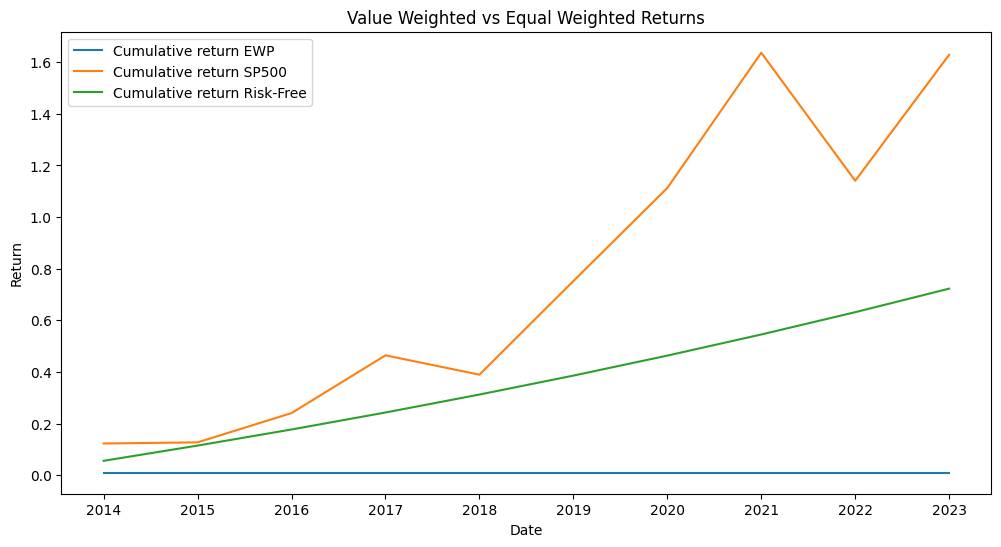

In [44]:
cumulative_returns_EWP = (returns_per_year["Annually_Return_EWP"]+1).cumprod() - 1
cumulative_returns_RiskFree = (returns_per_year["Annually_Return_with_Risk_Free_Asset"]+1).cumprod() - 1
cumulative_returns_SP500 = (returns_per_year["Annually_Return_with_SP500"]+1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(returns_per_year["Date"], cumulative_returns_EWP, label="Cumulative return EWP")
plt.plot(returns_per_year["Date"], cumulative_returns_SP500, label="Cumulative return SP500")
plt.plot(returns_per_year["Date"], cumulative_returns_RiskFree, label="Cumulative return Risk-Free")

plt.title(f"Value Weighted vs Equal Weighted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()

In [45]:
# Expected post Returns
ex_post_return = returns_per_year["Annually_Return_EWP"].mean()
risk = returns_per_year["Annually_Return_EWP"].std()
print(ex_post_return)
print(risk)

0.00097507798181216
0.003083467318806662
